# Evaluation

In [1]:
import os
import sys

# Data Science
import numpy as np
import pandas as pd

# load model
from joblib import load

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# from local
sys.path.append(os.path.abspath('../'))
from src.util import PD_feature_trasform, LGD_feature_trasform, EAD_feature_trasform 

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
test_df = pd.read_csv('../data/test/test.csv')

## Probability of Default (PD) Evaluation

In [3]:
pd_test_df = PD_feature_trasform(test_df)
TARGET_VARIABLE = 'default'


In [4]:
pd_model = load('../models/PD_model.joblib')

pd_y_test = pd_test_df[TARGET_VARIABLE]
pd_X_test = pd_test_df.drop(TARGET_VARIABLE, axis=1)
pd_X_test = pd_X_test.drop('id', axis=1)

# probabilities prediction
pd_y_pred_prob = pd_model.predict_proba(pd_X_test)[:,1]

# 0s and 1s prediction
pd_y_pred = pd_model.predict(pd_X_test)

# Precision, Recall, Accuracy
precision = precision_score(pd_y_test, pd_y_pred)
recall = recall_score(pd_y_test, pd_y_pred)
accuracy = accuracy_score(pd_y_test, pd_y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.70
Recall: 0.75
Accuracy: 0.67


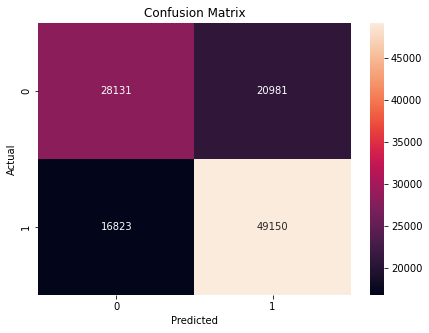

In [5]:
cm = confusion_matrix(pd_y_test, pd_y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

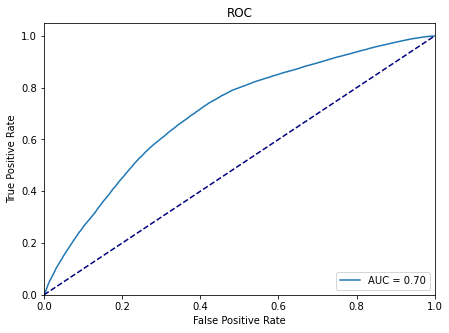

In [6]:
# AUC
auc = roc_auc_score(pd_y_test, pd_y_pred_prob)
fpr, tpr, thresholds = roc_curve(pd_y_test, pd_y_pred_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

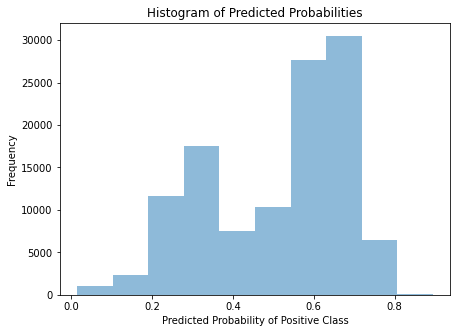

In [7]:
# Histogram of probabilities
plt.figure(figsize=(7,5))
plt.hist(pd_y_pred_prob, bins=10, alpha=0.5, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

## Loss Given Default (LGD) Evaluation

In [8]:
lgd_test_df = LGD_feature_trasform(test_df)
TARGET_VARIABLE = 'LGD'

In [9]:
lgd_y_test = lgd_test_df[TARGET_VARIABLE]
lgd_X_test = lgd_test_df.drop(TARGET_VARIABLE, axis=1)
lgd_X_test = lgd_X_test.drop('id', axis=1)

lgd_scaler = load('../models/scalers/LGD_scaler.joblib')
lgd_X_test = lgd_scaler.transform(lgd_X_test)


In [10]:
lgd_model = load('../models/LGD_model.joblib')

lgd_predictions = lgd_model.predict(lgd_X_test)

lgd_y_test_transformed = 1 - lgd_y_test
lgd_predictions_transformed = 1 - lgd_predictions

In [11]:
n_obs = lgd_y_test_transformed.shape[0]
lgd_r2 = r2_score(lgd_y_test, lgd_predictions)
lgd_rmse = np.sqrt(mean_squared_error(lgd_y_test_transformed, lgd_predictions_transformed))
lgd_mae = mean_absolute_error(lgd_y_test_transformed, lgd_predictions_transformed)
lgd_mse = mean_squared_error(lgd_y_test_transformed, lgd_predictions_transformed)

# Create a dataframe to hold the metrics
lgd_df_metrics = pd.DataFrame({
    'Number of Observations': [n_obs],
    'R2 Score': [lgd_r2],
    'RMSE': [lgd_rmse],
    'MAE': [lgd_mae],
    'MSE': [lgd_mse]
})

print(lgd_df_metrics)

   Number of Observations  R2 Score     RMSE       MAE       MSE
0                   16849  0.013004  0.09987  0.064067  0.009974


Eventhough the evaluation metrics and visualization shows that the model provide a much smaller distribution of the LGD, it is a good practice to apply a conservative modeling approach. It shows that the model is always predicting the loss rate higher, and there are no possibility of no loss (according to the distribution diagram and scatter) which is unpracticle, and this is because the bias on picking target variable, filtering the `loan_status` variable,  selecting features, and missing the consulting from domain expert. However, it is a good practice to apply the model.

There are 60 good features, and 61 most missing-values features (over 151 features) have not been evaluated yet. I will spend more time to evaluate the features

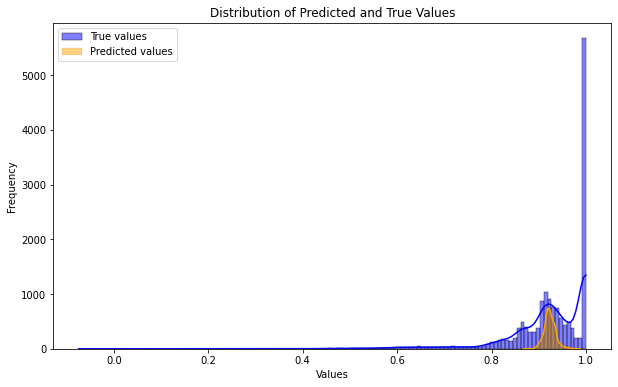

In [12]:
# Create a histogram
plt.figure(figsize=(10,6))
sns.histplot(lgd_y_test_transformed, color='blue', label='True values', kde=True)
sns.histplot(lgd_predictions_transformed, color='orange', label='Predicted values', kde=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Predicted and True Values')
plt.show()

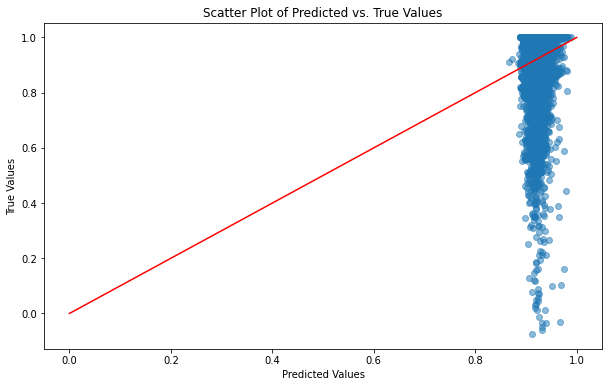

In [13]:
# Create a scatter plot
plt.figure(figsize=(10,6))
plt.scatter(lgd_predictions_transformed, lgd_y_test_transformed, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red')  # diagonal line
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')
plt.show()

## Exposure At Default (EAD) Evaluation

In [14]:
ead_test_df = EAD_feature_trasform(test_df)
TARGET_VARIABLE = 'EAD'

In [15]:
ead_y_test = ead_test_df[TARGET_VARIABLE]
ead_X_test = ead_test_df.drop(TARGET_VARIABLE, axis=1)
ead_X_test = ead_X_test.drop('id', axis=1)

ead_scaler = load('../models/scalers/EAD_scaler.joblib') 
ead_X_test = ead_scaler.transform(ead_X_test)

In [16]:
ead_model = load('../models/EAD_model.joblib')

ead_predictions = ead_model.predict(ead_X_test)

In [17]:
n_obs = ead_y_test.shape[0]
ead_r2 = r2_score(ead_y_test, ead_predictions)
ead_rmse = np.sqrt(mean_squared_error(ead_y_test, ead_predictions))
ead_mae = mean_absolute_error(ead_y_test, ead_predictions)
ead_mse = mean_squared_error(ead_y_test, ead_predictions)

# Create a dataframe to hold the metrics
df_metrics = pd.DataFrame({
    'Number of Observations': [n_obs],
    'R2 Score': [ead_r2],
    'RMSE': [ead_rmse],
    'MAE': [ead_mae],
    'MSE': [ead_mse]
})

print(df_metrics)

   Number of Observations  R2 Score         RMSE          MAE           MSE
0                   16849  0.329807  6207.396888  4803.751559  3.853178e+07


For the EAD model, it works better than LGD but they both don't have any relationship and the target feature's distribution of EAD is having a better shape. However, the model still produce below average with really small R2, and the absolute error is huge (~$5000). Evaluate on the un-evaluated features are necessary. 

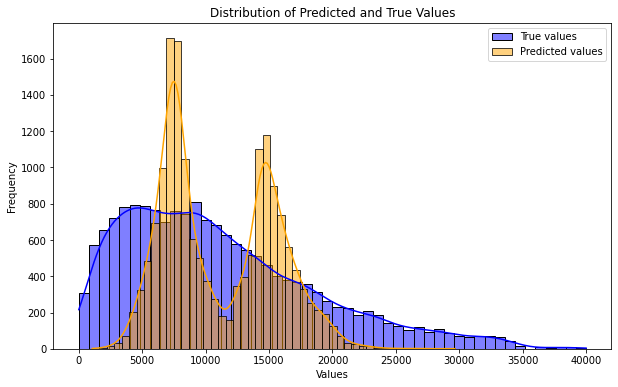

In [18]:
# Create a histogram
plt.figure(figsize=(10,6))
sns.histplot(ead_y_test, color='blue', label='True values', kde=True)
sns.histplot(ead_predictions, color='orange', label='Predicted values', kde=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Predicted and True Values')
plt.show()

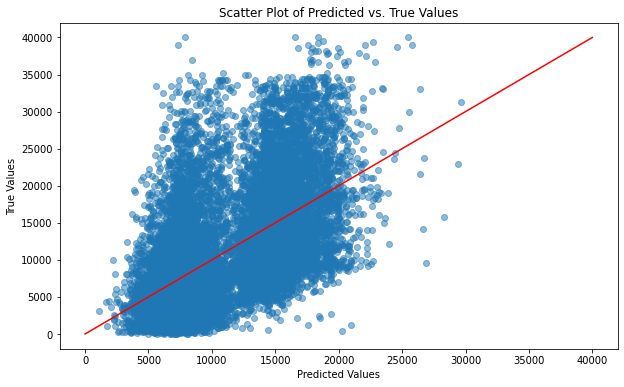

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(ead_predictions, ead_y_test, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')
plt.plot([0, 40000], [0, 40000], color='red')  # diagonal line

plt.show()